## Conditional Spectrum (CS) Based Record Selection for Multiple-Stripe Analysis (MSA) Upon Carrying out Probabilistic Seismic Hazard Analyss (PSHA) via OpenQuake
Created on: 26/08/2021

Author: Volkan Ozsarac

Affiliation: University School for Advanced Studies IUSS Pavia

Earthquake Engineering PhD Candidate

email:  volkan.ozsarac@iusspavia.it

In [1]:
from EzGM.selection import conditional_spectrum
from EzGM.utility import run_time, create_dir, hazard_curve, disagg_MR, disagg_MReps, check_gmpe_attributes, get_esm_token
from time import time
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Acquire the run start time
start_time = time()

### 1) Perform PSHA via OpenQuake

In [3]:
# %% Hazard Analysis via OpenQuake
# Set path to OpenQuake model .ini file path
parent_path = os.path.dirname(os.path.realpath(""))
oq_model = os.path.join(parent_path,'input files','OQ_Model') # this is the folder where oq model is located
oq_ini = 'job.ini' # this is .ini file used to run hazard model via openquake

# Set command to call OpenQuake
oq = 'oq'

# Directory to place post-processing results
post_dir = 'OQproc_Outputs'

# Read .ini file for post-processing purposes
with open(os.path.join(oq_model,oq_ini)) as f:
    info = f.readlines()
    for line in info:
        if line.startswith('poes'):
            poes = [float(poe) for poe in
                    line.split('\n')[0].split('=')[1].split(',')]
        if line.startswith('export_dir'):
            results_dir = os.path.join(oq_model, line.split('\n')[0].split('=')[1].strip())
        if line.startswith('mag_bin_width'):
            exec(line.strip())
        if line.startswith('distance_bin_width'):
            exec(line.strip())
        if line.startswith('reference_vs30_value'):
            exec(line.strip())


# Create the export directory for analysis results
create_dir(results_dir)

# Create the directory for processed results
create_dir(post_dir)

# Run the analysis via system command
cwd = os.getcwd() # Current working directory
os.chdir(oq_model) # Change directory, head to OQ_model folder
os.system(oq + ' engine --run ' + oq_ini + ' --exports csv')
os.chdir(cwd) # go back to the previous working directory

[2022-04-25 19:10:49 #23 INFO] volkan@volkan-VirtualBox running /home/volkan/Desktop/EzGM/Examples/input files/OQ_Model/job.ini [--hc=None]
[2022-04-25 19:10:49 #23 INFO] Using engine version 3.14.0
[2022-04-25 19:10:49 #23 WARNING] Using 2 cores on volkan-VirtualBox
[2022-04-25 19:10:49 #23 INFO] Checksum of the inputs: 2518209753 (total size 61.22 KB)
[2022-04-25 19:10:49 #23 INFO] Reading the risk model if present
[2022-04-25 19:10:49 #23 INFO] Read N=1 hazard sites and L=15 hazard levels
[2022-04-25 19:10:49 #23 INFO] Validated ssmLT.xml in 0.00 seconds
[2022-04-25 19:10:49 #23 INFO] Total number of logic tree paths = 1
[2022-04-25 19:10:49 #23 INFO] Reading the source model(s) in parallel
[2022-04-25 19:10:49 #23 INFO] read_source_model 100% [1 submitted, 0 queued]
[2022-04-25 19:10:49 #23 INFO] Received {'/home/volkan/Desktop/EzGM/Examples/input files/OQ_Model/ssm.xml': '19.72 KB'} in 0 seconds from read_source_model
[2022-04-25 19:10:49 #23 INFO] Checking the sources bounding bo

  id | name
  77 | Disaggregation Outputs
  78 | Full Report
  79 | Hazard Curves
  80 | Hazard Maps


### 2) Post-process PSHA results

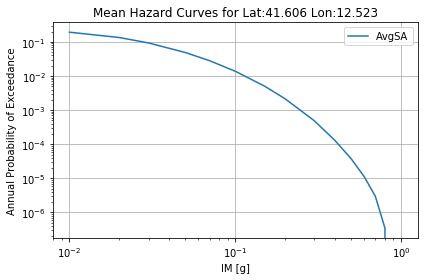

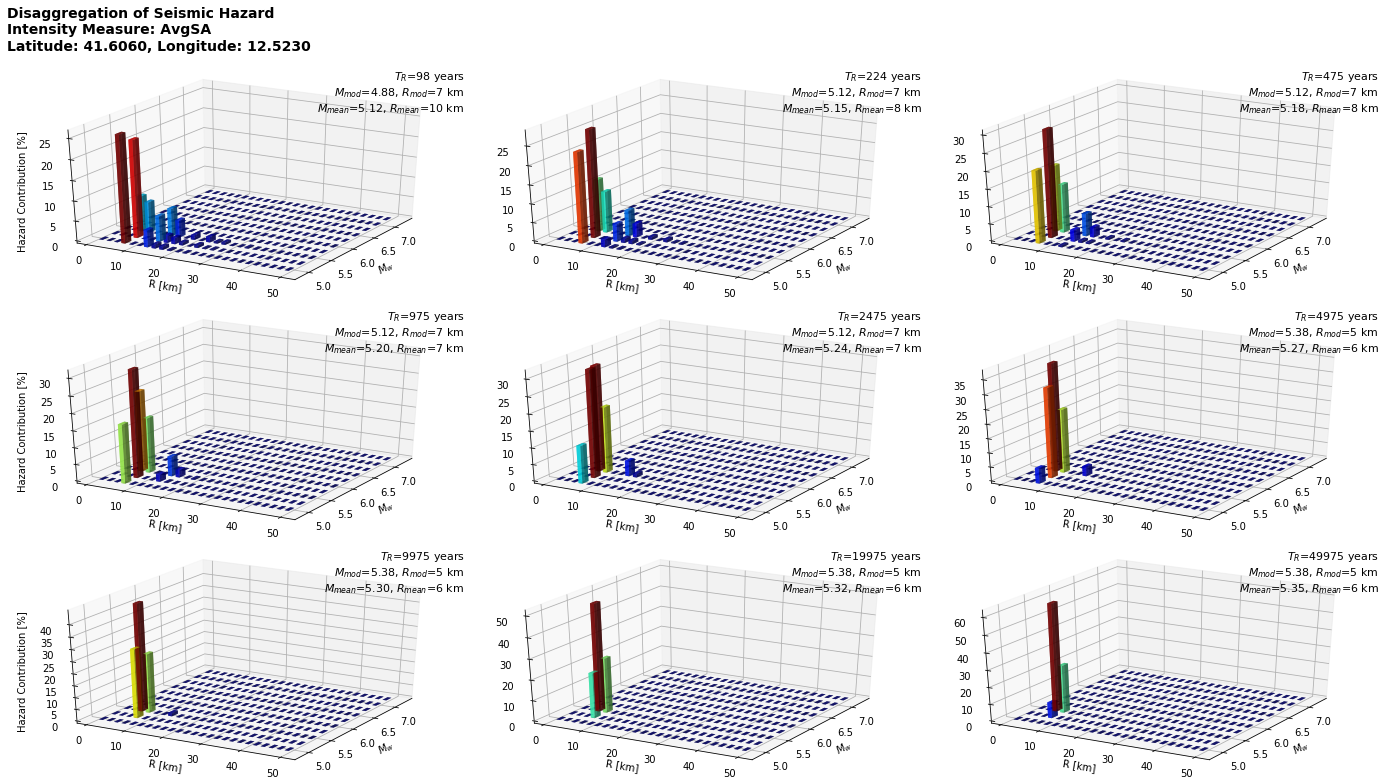

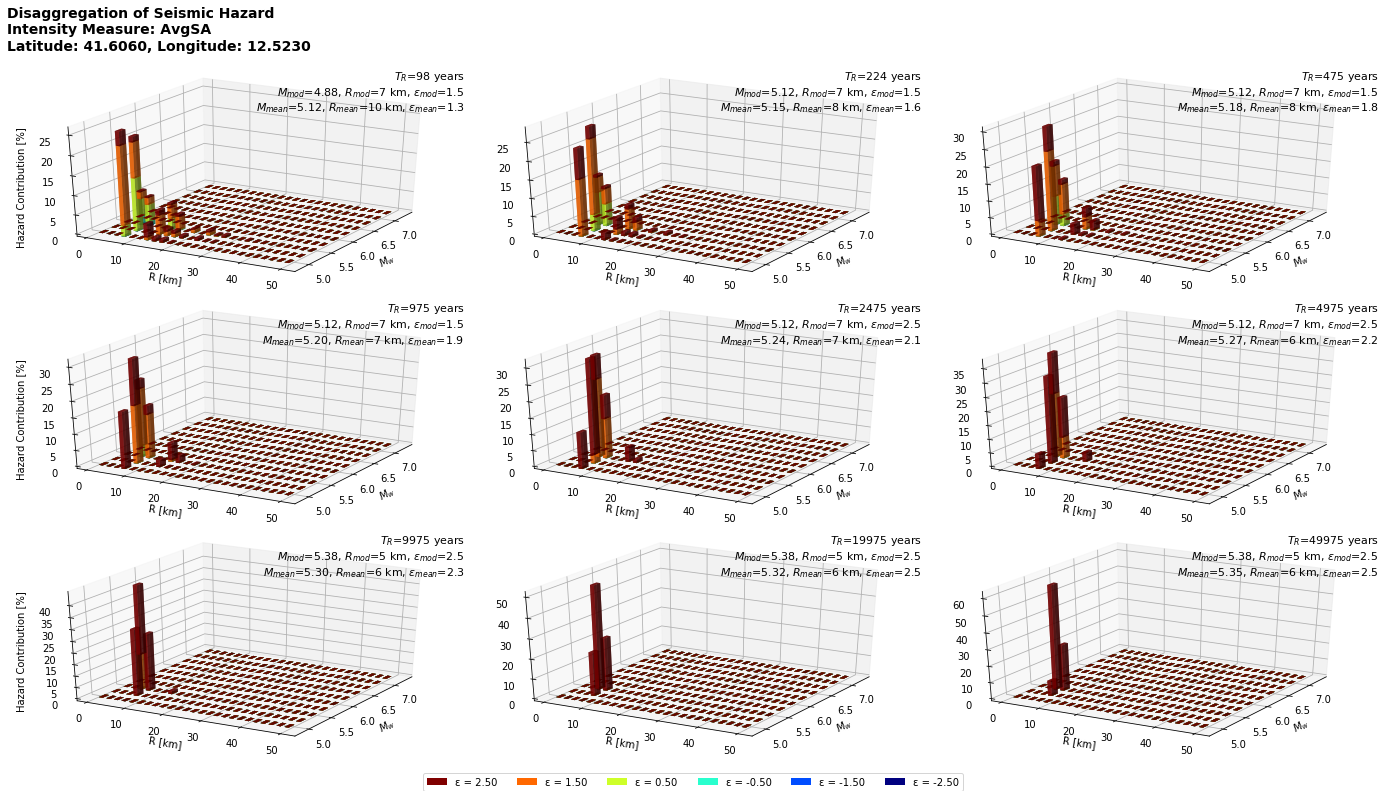

In [4]:
# Extract and plot hazard curves in a reasonable format
hazard_curve(poes, results_dir, post_dir)

# Extract and plot disaggregation results by M and R
disagg_MR(mag_bin_width, distance_bin_width, results_dir, post_dir, n_rows=3)

# Extract and plot disaggregation results by M, R and epsilon
disagg_MReps(mag_bin_width, distance_bin_width, results_dir, post_dir, n_rows=3)

### 3) Select the ground motions for different return periods, IM=AvgSA(T*)

In [5]:
# Get ESM token for ESM database.
get_esm_token(username = 'example_username@email.com', pwd = 'example_password123456')

# Check attributes of ground motion prediction equation BooreEtAl2014
check_gmpe_attributes(gmpe='BooreEtAl2014')

ims = []
for file in os.listdir(post_dir):
    if file.startswith('imls'):
        ims.append(file.split('_')[1].split('.')[0])

for im in ims:  # for each im in the im list
    # read hazard and disaggregation info
    imls = np.loadtxt(os.path.join(post_dir, 'imls_' + im + '.out'))
    mean_mags = np.loadtxt(os.path.join(post_dir, 'mean_mags_' + im + '.out'))
    mean_dists = np.loadtxt(os.path.join(post_dir, 'mean_dists_' + im + '.out'))

    for i in range(len(poes)):
        # 1.) Initialize the conditional_spectrum object for record selection, check which parameters are required for the gmpe you are using.
        cs = conditional_spectrum(database='ESM_2018', outdir=os.path.join('EzGM_Outputs_' + im, 'POE-' + str(poes[i]) + '-in-50-years'))
        
        # 2.) Create target spectrum
        cs.create(Tstar=np.arange(0.1, 1.1, 0.1), gmpe='BooreEtAl2014', selection=1, Sa_def='RotD50',
                  site_param={'vs30': reference_vs30_value}, rup_param={'rake': [0.0], 'mag': [mean_mags[i]]},
                  dist_param={'rjb': [mean_dists[i]]}, Hcont=None, T_Tgt_range=[0.05, 2.5],
                  im_Tstar=imls[i], epsilon=None, cond=1, useVar=1, corr_func='baker_jayaram')

        # 3.) Select the ground motions
        cs.select(nGM=25, isScaled=1, maxScale=4,
                  Mw_lim=None, Vs30_lim=None, Rjb_lim=None, fault_lim=None, nTrials=20,
                  weights=[1, 2, 0.3], seedValue=0, nLoop=2, penalty=1, tol=10)

        # Plot the target spectrum, simulated spectra and spectra of selected records
        cs.plot(tgt=0, sim=0, rec=1, save=1, show=0)
        plt.close('all')

        # 4.) Download Records
        # cs.ngaw2_download(username = 'example_username@email.com', pwd = 'example_password123456', sleeptime = 3, browser = 'firefox')
        cs.esm2018_download()

        # 5.) If you have records already inside recs_f\database.zip\database or
        # downloaded records for database = NGA_W2 case, write whatever you want,
        # the object itself, selected and scaled time histories
        cs.write(obj=1, recs=1, recs_f='')


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   866  100   649  100   217    619    207  0:00:01  0:00:01 --:--:--   826


GMPE name: BooreEtAl2014
Supported tectonic region: TRT.ACTIVE_SHALLOW_CRUST
Supported standard deviation: Inter event, Total, Intra event
Supported intensity measure: PGA, PGV, SA
Supported intensity measure component: IMC.RotD50
Supported SA period range: 0.01 - 10.0
Required distance parameters: rjb
Required rupture parameters: mag, rake
Required site parameters: vs30
Target spectrum is created.
Ground motion selection is finished.
For T ∈ [0.05 - 2.50]
Max error in median = 2.18 %
Max error in standard deviation = 6.50 %
The errors are within the target 10 percent %

Started executing esm2018_download method...
Downloaded files are located in
/home/volkan/Desktop/EzGM/Examples/binder/EzGM_Outputs_AvgSA/POE-0.4-in-50-years/unscaled_records_2022_4_25_17_12_11_0_115_0.zip
Finished writing process, the files are located in
/home/volkan/Desktop/EzGM/Examples/binder/EzGM_Outputs_AvgSA/POE-0.4-in-50-years
Target spectrum is created.
Ground motion selection is finished.
For T ∈ [0.05 - 2.5

Downloaded files are located in
/home/volkan/Desktop/EzGM/Examples/binder/EzGM_Outputs_AvgSA/POE-0.0025-in-50-years/unscaled_records_2022_4_25_17_19_3_0_115_0.zip
Finished writing process, the files are located in
/home/volkan/Desktop/EzGM/Examples/binder/EzGM_Outputs_AvgSA/POE-0.0025-in-50-years
Target spectrum is created.
Ground motion selection is finished.
For T ∈ [0.05 - 2.50]
Max error in median = 13.55 %
Max error in standard deviation = 7.79 %

Started executing esm2018_download method...
Downloaded files are located in
/home/volkan/Desktop/EzGM/Examples/binder/EzGM_Outputs_AvgSA/POE-0.001-in-50-years/unscaled_records_2022_4_25_17_19_50_0_115_0.zip
Finished writing process, the files are located in
/home/volkan/Desktop/EzGM/Examples/binder/EzGM_Outputs_AvgSA/POE-0.001-in-50-years


In [6]:
# Calculate the total time passed
run_time(start_time)

Run time: 0 hours: 9 minutes: 3.42 seconds
